In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

2023-11-24 13:33:56.509004: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 13:33:56.528352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 13:33:56.528371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 13:33:56.528381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 13:33:56.532384: I tensorflow/core/platform/cpu_feature_g

In [2]:
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time 
import pandas as pd

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# List all files in the current directory
files = os.listdir(current_directory)

# Print the list of files
print("\nFiles in the Current Directory:")
for file in files:
    print(file)

Current Directory: /mnt/c/Users/pc/Desktop/cw

Files in the Current Directory:
.ipynb_checkpoints
kaggle
trained_epochs
trained_epochs_1
yelp-review-predictions-using-huggingface-bert-Copy1.ipynb
yelp-review-predictions-using-huggingface-bert.ipynb
yelp_academic_dataset_review.json


In [4]:
reader = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize=20000)

In [5]:
def generate_dataset(json_reader, nrows=20000, min_length=100, max_length=512):
    df = pd.DataFrame()  # Initialize an empty DataFrame
    while True:
        df_candidate = next(json_reader)
        df_candidate = df_candidate.loc[(df_candidate['text'].str.len() > min_length) & (df_candidate['text'].str.len() <= max_length), ['text', 'stars']]
        if df.empty:
            df = df_candidate.copy()
        else:
            df = pd.concat([df, df_candidate], ignore_index=True)
        for rating in range(1, 6, 1):
            df_rating = df[df['stars'] == rating]
            if len(df_rating) > nrows // 5:
                df_rating = df_rating.iloc[:nrows // 5, :]
                df = df.loc[~(df['stars'] == rating), :]
                df = pd.concat([df, df_rating], ignore_index=True)
        if len(df) >= nrows:
            return df.iloc[:nrows, :]  # Return the first nrows rows

In [6]:
train_df = generate_dataset(reader)
test_df = generate_dataset(reader)

In [7]:
train_df['stars'].value_counts()

stars
1    4000
2    4000
3    4000
4    4000
5    4000
Name: count, dtype: int64

In [8]:
test_df['stars'].value_counts()

stars
1    4000
2    4000
3    4000
4    4000
5    4000
Name: count, dtype: int64

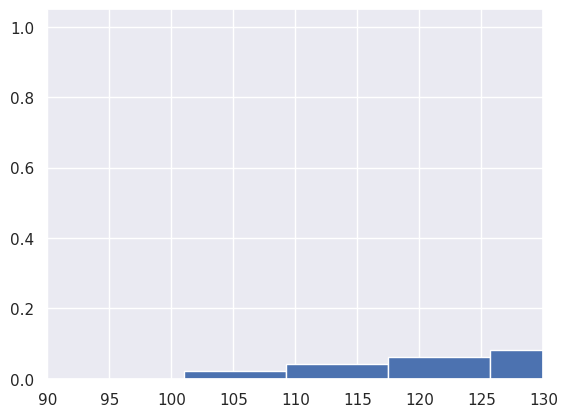

In [9]:
kwargs = {'cumulative': True}
plt.hist(train_df['text'].str.len().tolist() + test_df['text'].str.len().tolist(),cumulative=True, density=True, bins=50)
plt.xlim(left=90, right=130) 
plt.show()

In [10]:
train_df.head()

,text,stars
0,I am a long term frequent customer of this est...,1
1,The TV shows are $4.99 and they have commercia...,1
2,We visited once and were very disappointed in ...,1
3,Skip this train wreck if you are looking for d...,1
4,Service and management terrible... After messi...,1


In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
hidden_size = 200

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=hidden_size)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda();

loading file vocab.txt from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading file tokenizer.json from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json
loading configuration file config.json from cache at /home/yohan/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointi

Total model trainable parameters 109637045
Total head trainable parameters 154805


In [14]:
model.classifier

Linear(
  in_features=768, out_features=200, bias=True
  (bert_activation): Tanh()
  (prediction): Linear(in_features=200, out_features=5, bias=True)
)

In [15]:
tokenized = tokenizer.tokenize(' I am parachuting with you')
print(tokenized)
print(tokenizer.encode(tokenized, add_special_tokens=False))
print(tokenizer.encode(tokenized, add_special_tokens=True))

['i', 'am', 'para', '##chu', '##ting', 'with', 'you']
[1045, 2572, 11498, 20760, 3436, 2007, 2017]
[101, 1045, 2572, 11498, 20760, 3436, 2007, 2017, 102]


In [16]:
# https://huggingface.co/transformers/main_classes/processors.html
def get_features(df, text_col, label_col):
    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for 
       idx, row in tqdm(df.iterrows(), total=df.shape[0])]
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [17]:
train_dataset = get_features(train_df, 'text', 'stars')
test_dataset = get_features(test_df, 'text', 'stars')

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/yohan/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
*** Example ***
guid: 0
features: InputFeatures(input_ids=[101, 1045, 2572, 1037, 2146, 2744, 6976, 8013, 1997, 2023, 5069, 1012, 1045, 2074, 2253, 1999, 2000, 2344, 2202, 2041, 1006, 1017, 18726, 1007, 1998, 2001, 2409, 2027, 1005, 2128, 2205, 5697, 2000, 2079, 2009, 1012, 2428, 1029, 1996, 2173, 2003, 2672, 2431, 2440, 2012, 2190, 1012, 2515, 2115, 5980, 3362, 2115, 4632, 1029, 2748, 1029, 2175, 6616, 4426, 999, 1045, 1005, 1049, 1037, 6976, 8013, 1998, 2307, 5955, 4842, 1012, 5580, 2008, 8472, 4571, 2074, 2441, 1012, 2196, 2183,

  0%|          | 0/20000 [00:00<?, ?it/s]

*** Example ***
guid: 0
features: InputFeatures(input_ids=[101, 2044, 5094, 2026, 5542, 2933, 2014, 3819, 5030, 5353, 2023, 2851, 1037, 2261, 2477, 2020, 2200, 1999, 6413, 2043, 1996, 2194, 2234, 2000, 4060, 2037, 3941, 2039, 2044, 4092, 2000, 2968, 1998, 4487, 21338, 2229, 5051, 10985, 2011, 2068, 1045, 2097, 2196, 2412, 6749, 2068, 2000, 2178, 2711, 2009, 2001, 7078, 5510, 3238, 1996, 2126, 2057, 2020, 5287, 2000, 2096, 1045, 2001, 2036, 2001, 2108, 5496, 1997, 2477, 2008, 1045, 2196, 2056, 2054, 3047, 2000, 8013, 2326, 1029, 2092, 1045, 1005, 2222, 2425, 2017, 2054, 2023, 2194, 7078, 2038, 3904, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [19]:
# works
model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());

In [20]:
batch_size = 16
gradient_every = 32
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

epochs = 25

lr = 0.002
optimizer = AdamW(model.classifier.parameters(), lr=lr)  

/home/yohan/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
tr_losses = []
v_losses = []

In [22]:
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader)*epochs)
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda()}
        
        # Assuming model returns a tuple (loss, _)
        loss_tuple = model(**feed_dict)
        loss = loss_tuple[0]

        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss / accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda()} 

            # Assuming model returns a tuple (loss, pred)
            loss_tuple = model(**feed_dict)
            loss = loss_tuple[0]
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')

    # Define the folder name
    folder_name = 'trained_epochs'
    
    # Create the folder if it doesn't exist
    folder_path = os.path.join(os.getcwd(), folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the model's state dictionary in the folder
    torch.save(model.classifier.state_dict(), os.path.join(folder_path, f'yelp-head{epoch}.pt'))

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.403670813507504


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.289266858782087
epoch 2


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.2427442058457268


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.2816660158217899
epoch 3


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.1870333013004726


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.1288471676054455
epoch 4


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.1630253926912943


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.1150885035121252
epoch 5


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.1498089014689128


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.1345949939319067
epoch 6


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.120611874845293


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.1605025681238326
epoch 7


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.121683354218801


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.071994457926069
epoch 8


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.117124819225735


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0773697637376332
epoch 9


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.1104087913831076


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.2058534631653437
epoch 10


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.1116298897531298


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0758057425892542
epoch 11


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0927855232026842


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0686968129778665
epoch 12


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0925034359825982


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.1161118130835275
epoch 13


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0927096648746066


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0912790856664143
epoch 14


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0832831669383578


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0523847483453297
epoch 15


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0851050695313347


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0996616397585188
epoch 16


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0880880421002705


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0710148801879278
epoch 17


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.081691179646386


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0829075205893743
epoch 18


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0804847433302138


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.1066738367080688
epoch 19


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0782102285491095


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0962244574985807
epoch 20


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0669930324554444


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0616570616525316
epoch 21


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0671252466837564


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.057962141339741
epoch 22


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0781176562839083


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0701271636145455
epoch 23


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0584634148279826


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0218400330770583
epoch 24


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.059963504155477


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0354562534226313
epoch 25


batch:   0%|          | 0/1125 [00:00<?, ?it/s]

train NLL loss: 1.0625517008039687


val batch:   0%|          | 0/63 [00:00<?, ?it/s]

validation BCE loss: 1.0366494665070185


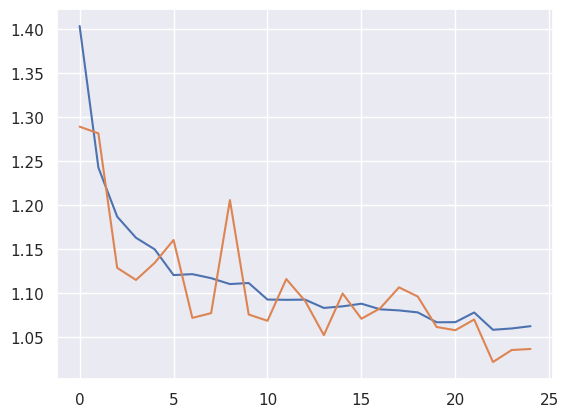

In [23]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [24]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/625 [00:00<?, ?it/s]

In [25]:
predictions = np.array([i for k in batch_predictions for i in k ])

predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])

In [26]:
from sklearn.metrics import f1_score
f1_score(actual, predictions, average='micro')

0.52965

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

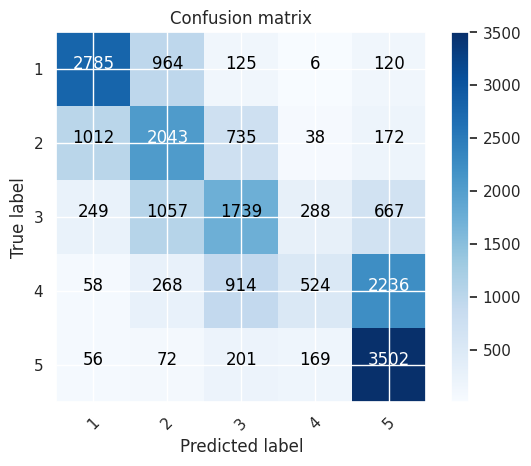

In [28]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()